# Pet Dog Behavior Study Analysis

## Table of Contents

1. [Workspace Setup](#setup)
2. [Overall Incidence](#overall)  
    2.1 [Preparation of data](#overall-1)  
    2.2 [Total survey participants](#overall-2)  
    2.3 [Total participants that reported a behavior problem](#overall-3)  
    2.4 [Total participants that reported a bahavior problem but joined for other reasons](#overall-4)  
    2.5 [Overall incidence summary](#overall-5)  
3. [Separation Anxiety, Noise Phobia, and Thunderstorm Phobia](#first)  
    3.1 [Preparation of data](#first-1)  
    3.1 [Tables and calculations](#first-2)  
    3.1 [Further exploration](#first-3)  
4. [Compulsion and Fearful/Anxious Behaviors](#second)  
    4.1 [Preparation of data](#second-1)  
    4.1 [Tables and calculations](#second-2)  
5. [Aggression and Fearful/Anxious Behavior](#third)  
    5.1 [Preparation of data](#third-1)  
    5.1 [Tables and calculations](#third-2)  
6. [Reasons for Joining the Study](#fourth)  
    6.1 [Preparation of data](#fourth-1)  
    6.1 [Breakdown of reasons for joining the study](#fourth-2) 

<a id='setup'></a>
# 1. Workspace Setup

In [1]:
import sqlite3
import pandas as pd
import textwrap
import scipy.stats as scs
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt


# Establish a connection to the database.
con = sqlite3.connect('../data/processed/processed.db')

<a id='overall'></a>
## 2. Overall Incidence

<a id='overall-1'></a>
### 2.1 Preparation of data

In [2]:
# Create the necessary dataframe.
query = ('SELECT record_id, question_reason_for_part_3, q02_score FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['id', 'reason', 'problems']
df['problems'] = pd.to_numeric(df['problems'])

# Remove duplicates, but preserve highest count of reported problems for each.
df = df.sort_values('problems', ascending=False).drop_duplicates('id').sort_index()

<a id='overall-2'></a>
### 2.2 Total survey participants

In [3]:
# Get a count of the total number of participants.
cnt_total_users = len(df.index)
print('Total participants: %d' %cnt_total_users)

Total participants: 2986


<a id='overall-3'></a>
### 2.3 Total participants that reported a behavior problem

In [4]:
# Determine the total number of participants who reported behavior problems.
cnt_any_w_problems = len(df[df.problems != 0].index)
print('Total participants who reported behavior problems: %d ' %cnt_any_w_problems)

Total participants who reported behavior problems: 2810 


<a id='overall-4'></a>
### 2.4 Total participants that reported a bahavior problem but joined for other reasons

In [5]:
diff_reason = df[df.reason != '1']
diff_w_problem = diff_reason[diff_reason.problems != 0]
cnt_diff_w_problem = len(diff_w_problem.index)
result = ('Participants who reported behavior problems, but did not list the behavior '
          'problems as the reason for joining the study: %d' %cnt_diff_w_problem)
print(textwrap.fill(result, width=90))

Participants who reported behavior problems, but did not list the behavior problems as the
reason for joining the study: 2043


<a id='overall-5'></a>
### 2.5 Overall incidence summary

In [6]:
pct_any_reason = cnt_any_w_problems / cnt_total_users
summary = ('Behavior problems were reported by %d of the total %d participants (%.2f%%). '
           %(cnt_any_w_problems, cnt_total_users, pct_any_reason))

cnt_diff_reason = cnt_total_users - (cnt_any_w_problems - cnt_diff_w_problem)
pct_diff_reason = cnt_diff_w_problem / cnt_diff_reason
summary += ('After removing participants who listed behavior problems as a reason for '
            'joining the study, behavior problems were reported by %d of the remaining %d '
            'participants (%.2f%%).' %(cnt_diff_w_problem, cnt_diff_reason, pct_diff_reason))

print(textwrap.fill(summary, width=90))

Behavior problems were reported by 2810 of the total 2986 participants (0.94%). After
removing participants who listed behavior problems as a reason for joining the study,
behavior problems were reported by 2043 of the remaining 2219 participants (0.92%).


<a id='first'></a>
## 3. Separation Anxiety, Noise Phobia, and Thunderstorm Phobia

<a id='first-1'></a>
### 3.1 Preparation of data

In [7]:
# Create the necessary dataframe.
query = ('SELECT q04_1, q04_2, q04_9 FROM dogs')
df = pd.read_sql_query(query, con)
df.columns = ['thunderstorm phobia', 'noise phobia', 'separation anxiety']
for col in df:
    df[col] = pd.to_numeric(df[col])
    
# Set a significance level.
sig_p = 0.01
    
# Record the total number of dogs.
cnt_total_dogs = len(df.index)
print('Total dogs: %d' %cnt_total_dogs)

Total dogs: 5018


<a id='first-2'></a>
### 3.2 Tables and calculations

In [8]:
pairs = [['thunderstorm phobia', 'noise phobia'],
         ['thunderstorm phobia', 'separation anxiety'],
         ['noise phobia', 'separation anxiety']
        ]
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    display(contingency)
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    if p < sig_p:
        print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

noise phobia,0,1
thunderstorm phobia,,
0,3839,427
1,210,542


Chi-squared Test of Independence for thunderstorm phobia and noise phobia:
chi2 = 1580.493072, p = 0.00E+00, dof = 1
The resulting p-value is below the set significance threshold (0.01).


separation anxiety,0,1
thunderstorm phobia,,
0,3750,516
1,501,251


Chi-squared Test of Independence for thunderstorm phobia and separation anxiety:
chi2 = 223.618927, p = 1.47E-50, dof = 1
The resulting p-value is below the set significance threshold (0.01).


separation anxiety,0,1
noise phobia,,
0,3592,457
1,659,310


Chi-squared Test of Independence for noise phobia and separation anxiety:
chi2 = 258.860919, p = 3.04E-58, dof = 1
The resulting p-value is below the set significance threshold (0.01).


<a id='first-3'></a>
### 3.3 Further exploration

In [9]:
# Create a contingency table.
contingency = pd.crosstab(df['separation anxiety'], [df['noise phobia'],
                                                     df['thunderstorm phobia']])
display(contingency.style)

# Execute a chi-squared test of independence.
title = ('Chi-squared Test of Independence for separation anxiety and the combination of '
         'noise and thunderstorm phobia:')
print(textwrap.fill(title, width=90))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

Chi-squared Test of Independence for separation anxiety and the combination of noise and
thunderstorm phobia:
chi2 = 343.870316, p = 3.17E-74, dof = 3
The resulting p-value is below the set significance threshold (0.01).


<a id='second'></a>
## 4. Compulsion and Fearful/Anxious Behaviors

<a id='second-1'></a>
### 4.1 Preparation of data

In [10]:
# Create the necessary dataframe.
query = ('SELECT q02_main_2, q02_main_3 FROM dogs')
df = pd.read_sql_query(query, con)
df.columns = ['fearful/anxious behavior', 'repetitive behavior']
for col in df:
    df[col] = pd.to_numeric(df[col])

<a id='second-2'></a>
### 4.1 Tables and calculations

In [11]:
# Create a contingency table.
contingency = pd.crosstab(df['fearful/anxious behavior'], df['repetitive behavior'])
display(contingency)

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

repetitive behavior,0,1
fearful/anxious behavior,,
0,2307,324
1,1893,494


Chi-square Test of Independence:
chi2 = 64.426486, p = 1.00E-15, dof = 1
The resulting p-value is below the set significance threshold (0.01).


<a id='third'></a>
## 5. Aggression and Fearful/Anxious Behavior

<a id='third-1'></a>
### 5.1 Preparation of data

In [12]:
# Create the necessary dataframe.
query = ('SELECT q02_main_1, q02_main_2 FROM dogs')
df = pd.read_sql_query(query, con)
df.columns = ['aggression', 'fearful/anxious behavior']
for col in df:
    df[col] = pd.to_numeric(df[col])

<a id='third-2'></a>
### 5.1 Tables and calculations

In [13]:
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['fearful/anxious behavior'])
display(contingency)

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

fearful/anxious behavior,0,1
aggression,,
0,1905,1325
1,726,1062


Chi-square Test of Independence:
chi2 = 155.793414, p = 9.39E-36, dof = 1
The resulting p-value is below the set significance threshold (0.01).


<a id='fourth'></a>
## 6. Reasons for Joining the Study

<a id='fourth-1'></a>
### 6.1 Preparation of data

In [14]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_1, question_reason_for_part_2, '  
         'question_reason_for_part_3, question_reason_for_part_4, '
         'question_reason_for_part_5 FROM users')
df = pd.read_sql_query(query, con)
df.columns = ['love', 'shelter animals', 'problems', 'work', 'other']
for col in df:
    df[col] = pd.to_numeric(df[col])

<a id='fourth-2'></a>
### 6.2 Breakdown of reasons for joining the study

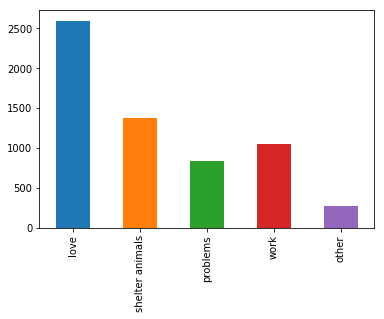

In [15]:
# Create a bar graph to illustrate breakdown of responses.
df.sum().plot(kind='bar')